# Overview


For the molecule lovers in the audience, let's calculate a transition state for the C-H bond dissociation of methane (CH4). For this exercise, we will use a semi-empirical quantum chemistry method called GFN1-xTB as our calculator (https://pubs.acs.org/doi/abs/10.1021/acs.jctc.8b01176). We will cover such methods later, and it is not the focal point for now.

Note: We are not using the newer GFN2-xTB because for some reason, the transition state search does not identify a reasonable structure with that method. Beats me, but we move on.


# Setup


To install the dependencies, please run

Mac/Linux:

```bash
uv pip install ase tblite sella
```

Windows:

```bash
uv pip install ase sella
conda install -c conda-forge tblite-python
```


# Demonstration


We start by making the CH4 molecule. You can look up the XYZ coordinates of the molecule or just use the built-in one in ASE.


In [ ]:
from ase.build import molecule

ch4 = molecule("CH4")

Let's make sure to relax the geometry to have a local minimum energy structure to start.


In [ ]:
from ase.optimize import BFGS
from tblite.ase import TBLite

initial = ch4.copy()
initial.calc = TBLite(method="GFN1-xTB", verbosity=0)
opt = BFGS(initial)
opt.run(fmax=0.01)

      Step     Time          Energy          fmax
BFGS:    0 23:49:34     -116.307955        0.122664
BFGS:    1 23:49:34     -116.308607        0.063042
BFGS:    2 23:49:34     -116.308838        0.000708


np.True_

Now we need a guess for the product state, which should be a CH3 radical and H radical separated from one another. We can achieve this by increase a C-H bond distance to some large value like 5.0 A.


In [ ]:
final = initial.copy()
final.set_distance(0, 1, 5.0, fix=0)  # 0 = C, 1 = H

Let's make sure we made what we think we've made.


In [ ]:
from ase.visualize import view

view(final)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

Now let's optimize the product state. We will discuss this more later, but we need to be careful about spin. CH3 and H in the dissociated product are both radical species, meaning they each have one unpaired electron. Electronic structure codes, including some semi-empirical quantum chemistry codes and even some machine learning potentials, take the number of unpaired electrons (and charge) as an input parameter. Here, multiplicity is simply the number of unpaired electrons + 1, which would be 3 for the product state. If you did not set `multiplicity=3`, the calculation would crash and tell you it could not converge.


In [ ]:
final.calc = TBLite(method="GFN1-xTB", multiplicity=3, verbosity=0)
opt = BFGS(final)
opt.run(fmax=0.01)

      Step     Time          Energy          fmax
BFGS:    0 23:49:34     -109.537929        1.711877
BFGS:    1 23:49:34     -109.586704        1.228032
BFGS:    2 23:49:34     -109.689600        0.454364
BFGS:    3 23:49:34     -109.731615        0.210406
BFGS:    4 23:49:34     -109.739017        0.196169
BFGS:    5 23:49:34     -109.740615        0.170129
BFGS:    6 23:49:34     -109.743877        0.030166
BFGS:    7 23:49:34     -109.744234        0.013866
BFGS:    8 23:49:34     -109.744272        0.001398


np.True_

The NEB method is really difficult to use in cases where the spin state can change between the reactants and products because the NEB method generally keeps the spin state fixed through the course of the MEP search process even if the images might become more reactant- or more product-like.


Since this is a simple reaction, we can manually scan the reaction coordinate and identify the structure associated with the highest energy configuration. We will linearly interpolate using the NEB module for convenience but won't use the NEB method itself here.


In [ ]:
from ase.mep import NEB

images = [initial] + [initial.copy() for _ in range(10)] + [final]
neb = NEB(images, method="improvedtangent")
neb.interpolate()

In [ ]:
view(images)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

Now we will calculate the energy of each intermediate image. This is called a static scan because we are not relaxing the intermediate images at all. This is not a true MEP we are mapping, but it will give us a reasonable start.

Note that I have forced each intermediate image to have `multiplicity=3`. This was based on personal experience. You could tinker with this since at some point along the MEP, it must cross from `multiplicity=1` (initial state) and `multiplicity=3` (final state).


In [ ]:
for i, image in enumerate(images[1:-1], start=1):
    image.calc = TBLite(method="GFN1-xTB", multiplicity=3, verbosity=0)
    e = image.get_potential_energy()
    print(f"Image {i}: Energy = {e} eV")

Image 1: Energy = -106.49679491858966 eV
Image 2: Energy = -108.61858415493906 eV
Image 3: Energy = -109.4140082898563 eV
Image 4: Energy = -109.64288520877973 eV
Image 5: Energy = -109.7028919026513 eV
Image 6: Energy = -109.72007416362852 eV
Image 7: Energy = -109.72845023534455 eV
Image 8: Energy = -109.73478581797747 eV
Image 9: Energy = -109.73979108800074 eV
Image 10: Energy = -109.74316648653313 eV


Great. Now let's plot the results. It does not make sense to plot absolute energies, so we will normalize everything by the lowest energy structure (the reactant). We will also plot the energy as a function of our reaction coordinate, which is the C-H bond distance.


Text(0.5, 0, 'C-H Bond Distance (Å)')

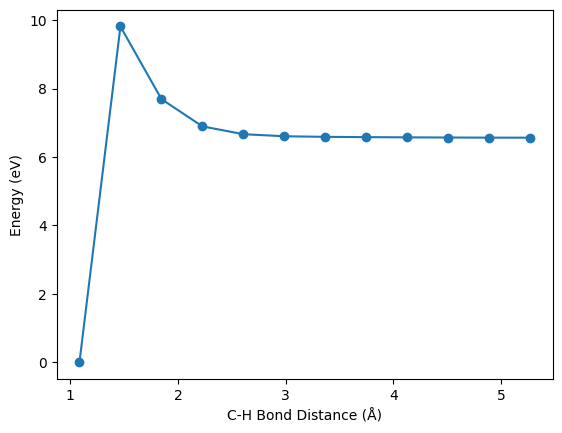

In [ ]:
from matplotlib import pyplot as plt

energies = [image.get_potential_energy() for image in images]
energies = [e - min(energies) for e in energies]
ch_bond_dist = [image.get_distance(0, 1) for image in images]

plt.plot(ch_bond_dist, energies, marker="o")
plt.ylabel("Energy (eV)")
plt.xlabel("C-H Bond Distance (Å)")

From here, we have a decent estimate of the activation energy (and an unambiguous determination of the reaction energy).


In [ ]:
barrier = max(energies) - energies[0]
rxn_energy = energies[-1] - energies[0]
print(f"Activation Barrier: {barrier * 96.49} kJ/mol")
print(f"Reaction Energy: {rxn_energy * 96.49} kJ/mol")

Activation Barrier: 946.7640463329658 kJ/mol
Reaction Energy: 633.414975416312 kJ/mol


The experimental values are known. For instance, the kinetics can be found at https://kinetics.nist.gov/kinetics and the thermodynamics in the CRC Handbook.

The values are way off. The bond-dissociation enthalpy of methane is 439 kJ/mol. Granted, this is enthalpy at room temperature and we are only reporting the electronic (0 K) energy, but the enthalpic corrections are very small.

It turns out the the semi-empirical GFN-xTB methods are pretty bad at predicting energies, including both GFN1-xTB and GFN2-xTB. In fact, the name suggests what they are good for: geometries, frequencies, and non-covalent interactions. But it was fast, so we used it here anyway. The same exercise could be done with a more accurate calculator.


The example above was a static scan, and there is no guarantee that the highest energy structure was _exactly_ the transition state. We can take the highest energy image and pass it to a saddle point search algorithm. A fancy one is called Sella (https://pubs.acs.org/doi/full/10.1021/acs.jctc.2c00395).


First, we identify the highest energy structure and use that as our guess for the transition state.


In [ ]:
import numpy as np

ts_idx = np.argmax(energies)
ts_guess = images[ts_idx]

In [ ]:
view(ts_guess)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

Then we run a typical ASE optimization except here the optimizer is `Sella` instead of something like `BFGS`. We do not know in advance if the transition state has no unpaired electrons (like the reactant) or 2 unpaired electrons (like the products), so we will try both and look at the resulting structures. It will be pretty obvious which is really the transition state.

Actually, upon running this, we find that the `multiplicity=1` case does not even converge at all, so that settles it.


In [ ]:
ts_guess1 = ts_guess.copy()
ts_guess2 = ts_guess.copy()
ts_guess1.calc = TBLite(method="GFN1-xTB", multiplicity=1, verbosity=0)
ts_guess2.calc = TBLite(method="GFN1-xTB", multiplicity=3, verbosity=0)

In [ ]:
from sella import Sella

# order = 1 for TS; order = 0 for geometry opt
# internal = True to use internal coordinates for speedup; only works for molecules
try:
    opt = Sella(ts_guess1, trajectory="ts.traj", order=1, internal=True)
    opt.run(fmax=0.01)
except Exception:
    print("Spin multiplicity 1 optimization failed")

try:
    opt = Sella(ts_guess2, trajectory="ts2.traj", order=1, internal=True)
except Exception:
    print("Spin multiplicity 3 optimization failed")
opt.run(fmax=0.01)

     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 23:49:38     -115.049252       4.8467       0.0000       0.1000       1.0000


c:\Users\asros\miniconda3\envs\cms\Lib\site-packages\ase\optimize\optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '


Sella   1 23:49:40     -114.687363       5.5491       0.0000       0.1150       1.0119


c:\Users\asros\miniconda3\envs\cms\Lib\site-packages\ase\optimize\optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '


Sella   2 23:49:40     -114.198383       6.3115       0.0000       0.1150       1.0644
Sella   3 23:49:41     -113.697959       6.5600       0.0000       0.1150       1.0914
Sella   4 23:49:41     -113.294791       6.6283       0.0000       0.1150       1.0359
Sella   5 23:49:41     -112.979865       6.8471       0.0000       0.1322       0.9909
Sella   6 23:49:41     -112.446764       7.0650       0.0000       0.1521       1.0310
Sella   7 23:49:42     -111.780248       6.9138       0.0000       0.1749       1.0021
Sella   8 23:49:42     -111.158250       6.7222       0.0000       0.2011       1.0061
Sella   9 23:49:42     -110.728549       6.4177       0.0000       0.2313       0.9826
Sella  10 23:49:42     -110.307171       6.0037       0.0000       0.2313       0.9619
Sella  11 23:49:42     -110.062910       5.3313       0.0000       0.2313       0.9395
Sella  12 23:49:42     -109.915318       4.4954       0.0000       0.2313       0.9239
Sella  13 23:49:43     -109.844008       3.

np.True_

It is pretty clear that the TS is the second one (`multiplicity=3`). We will proceed with that one.


In [ ]:
ts = ts_guess2
view(ts)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

In [ ]:
ea = ts.get_potential_energy() - initial.get_potential_energy()
print(f"Refined Activation Energy: {ea * 96.49} kJ/mol")

Refined Activation Energy: 952.8969438352743 kJ/mol


Let's confirm it's a transition state with a vibrational analysis.


In [ ]:
from ase.vibrations import Vibrations

vib = Vibrations(ts)
vib.run()
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   17.4i    140.3i
  1   32.0     258.1
  2   32.8     264.2
  3   88.8     715.9
  4  142.3    1147.8
  5  167.9    1353.9
  6  177.0    1427.6
  7  179.2    1445.5
  8  214.0    1725.6
  9  217.8    1756.4
 10  225.3    1816.9
 11  232.4    1874.1
 12  240.6    1940.8
 13  249.6    2012.9
 14  262.4    2116.5
---------------------
Zero-point energy: 1.231 eV


One imaginary mode! Let's check it out.


In [ ]:
vib.write_mode(0)

That indeed looks like the right one! Our mission is complete.

Sella also provides an option to carry out an IRC analysis to confirm the TS connects the proposed reactants and products, but we will forego doing so here for the sake of time.
